In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Оценка стоимости кварталов

In [2]:
blocks_gdf = gpd.read_parquet('data/blocks_maks.parquet')
blocks_gdf.columns

Index(['geometry', 'land_use', 'is_living', 'build_floor_area',
       'living_demand', 'living_area', 'share_living', 'business_area',
       'share_business', 'site_area', 'population', 'footprint_area', 'fsi',
       'gsi', 'l', 'osr', 'mxi', 'capacity_convenience', 'capacity_cafe',
       'capacity_mall', 'capacity_pharmacy', 'capacity_bank', 'capacity_fuel',
       'capacity_pitch', 'capacity_playground', 'capacity_museum',
       'capacity_parking', 'capacity_bakery', 'capacity_restaurant',
       'capacity_dog_park', 'capacity_university', 'capacity_police',
       'capacity_bar', 'capacity_park', 'capacity_government',
       'capacity_supermarket', 'capacity_kindergarten', 'capacity_polyclinic',
       'capacity_school', 'capacity_religion', 'capacity_post',
       'capacity_hairdresser', 'capacity_theatre', 'capacity_stadium',
       'capacity_cemetery', 'capacity_substation', 'capacity_hotel',
       'capacity_hospital', 'capacity_multifunctional_center',
       'capacity_sw

In [3]:
# from blocksnet.analysis.morphotypes import get_strelka_morphotypes

# blocks_df = get_strelka_morphotypes(blocks_gdf)
# blocks_gdf = blocks_gdf.join(blocks_df[['morphotype']], how='left')
# blocks_df.head()

In [4]:
# cadastr_land = gpd.read_parquet('data/spb_land_cad.parquet')
cadastr_blocks = gpd.read_parquet('data/spb_bloks_price.parquet')
cadastr_blocks.head()

,cadastralDistrictsCode,readable_address,cost_value,cost_index,land_record_category_type,permitted_use_established_by_document,specified_area,geometry
0,78,"Санкт-Петербург, город Зеленогорск, Решетников...",10833260.98,5846.3362,Земли населенных пунктов,для размещения индивидуального жилого дома (ин...,1852.0,"POLYGON ((3306132.351 8453357.197, 3306131.265..."
1,78,"г.Санкт-Петербург, город Зеленогорск, Решетник...",6533139.72,5444.2831,Земли населенных пунктов,для размещения индивидуального жилого дома (ин...,1200.0,"POLYGON ((3306613.198 8453876.707, 3306609.831..."
2,78,"Санкт-Петербург, город Зеленогорск, Красавица,...",16395.97,1366.3305,Земли населенных пунктов,Для размещения объектов коммунального хозяйства,12.0,"POLYGON ((3311932.709 8453466.264, 3311927.608..."
3,78,"Санкт-Петербург, город Зеленогорск, Решетников...",8425371.37,5513.9865,Земли населенных пунктов,Для размещения индивидуального (одноквартирног...,1528.0,"POLYGON ((3306341.721 8454345.055, 3306347.49 ..."
4,78,"Санкт-Петербург, город Зеленогорск, Решетников...",11430710.60,5715.3553,Земли населенных пунктов,для размещения индивидуального жилого дома (ин...,2000.0,"POLYGON ((3306583.407 8453412.704, 3306580.412..."


In [5]:
cadastr_blocks['log_cost_index'] = np.log1p(cadastr_blocks['cost_index'])

In [6]:
blocks_gdf['log_population'] = np.log1p(blocks_gdf['population'])

/Users/mvin/Code/blocksnet/.venv/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


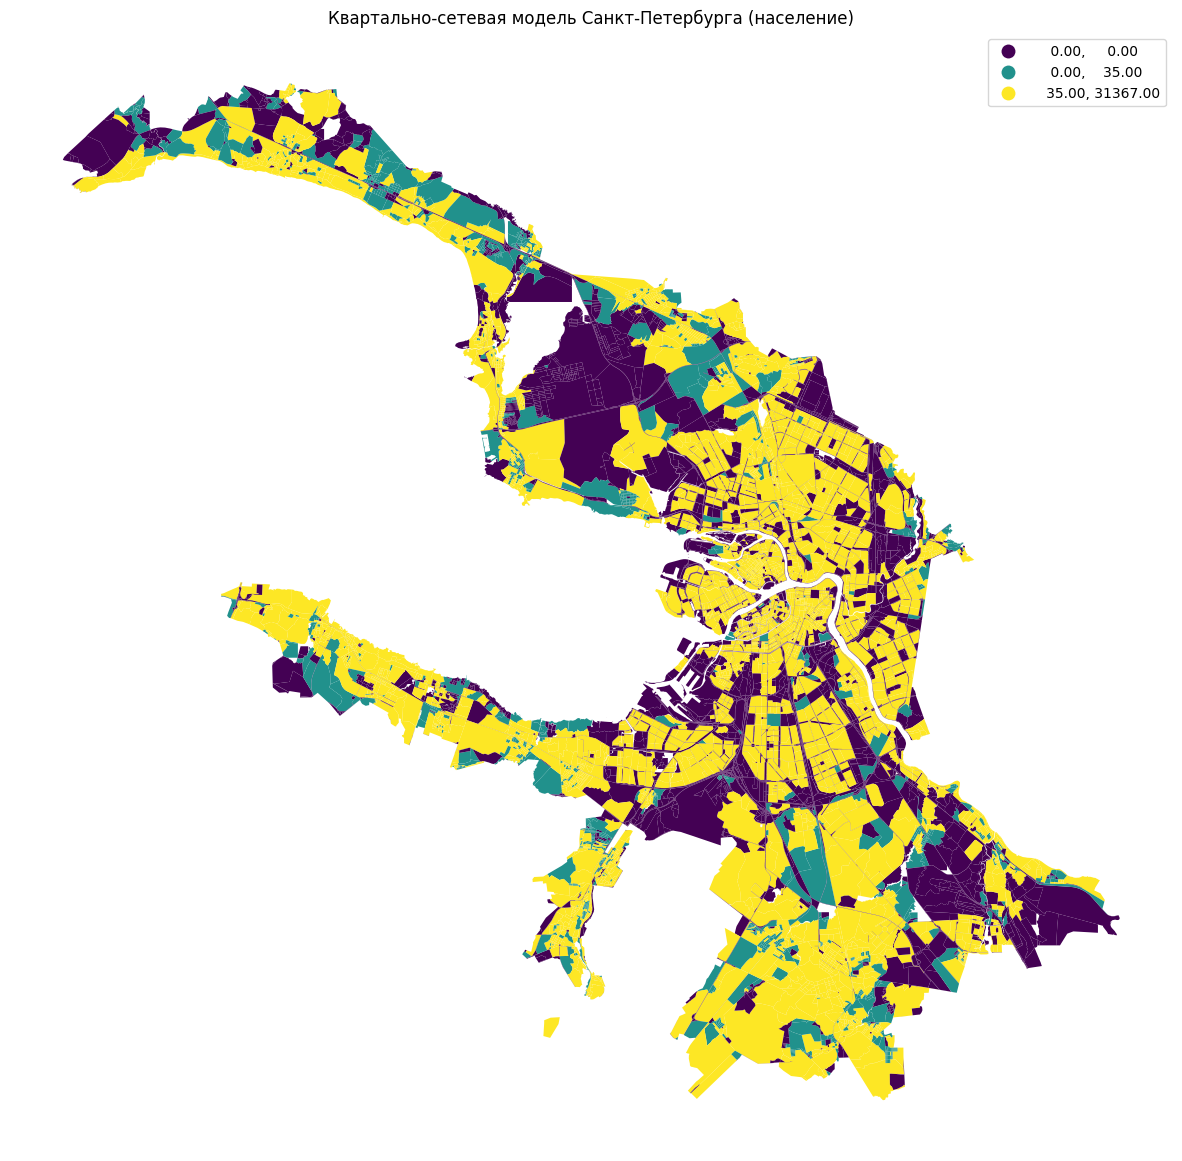

In [7]:
# Картируем лог-цену
blocks_gdf.plot(
    column='population',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Квартально-сетевая модель Санкт-Петербурга (население)')

plt.show()

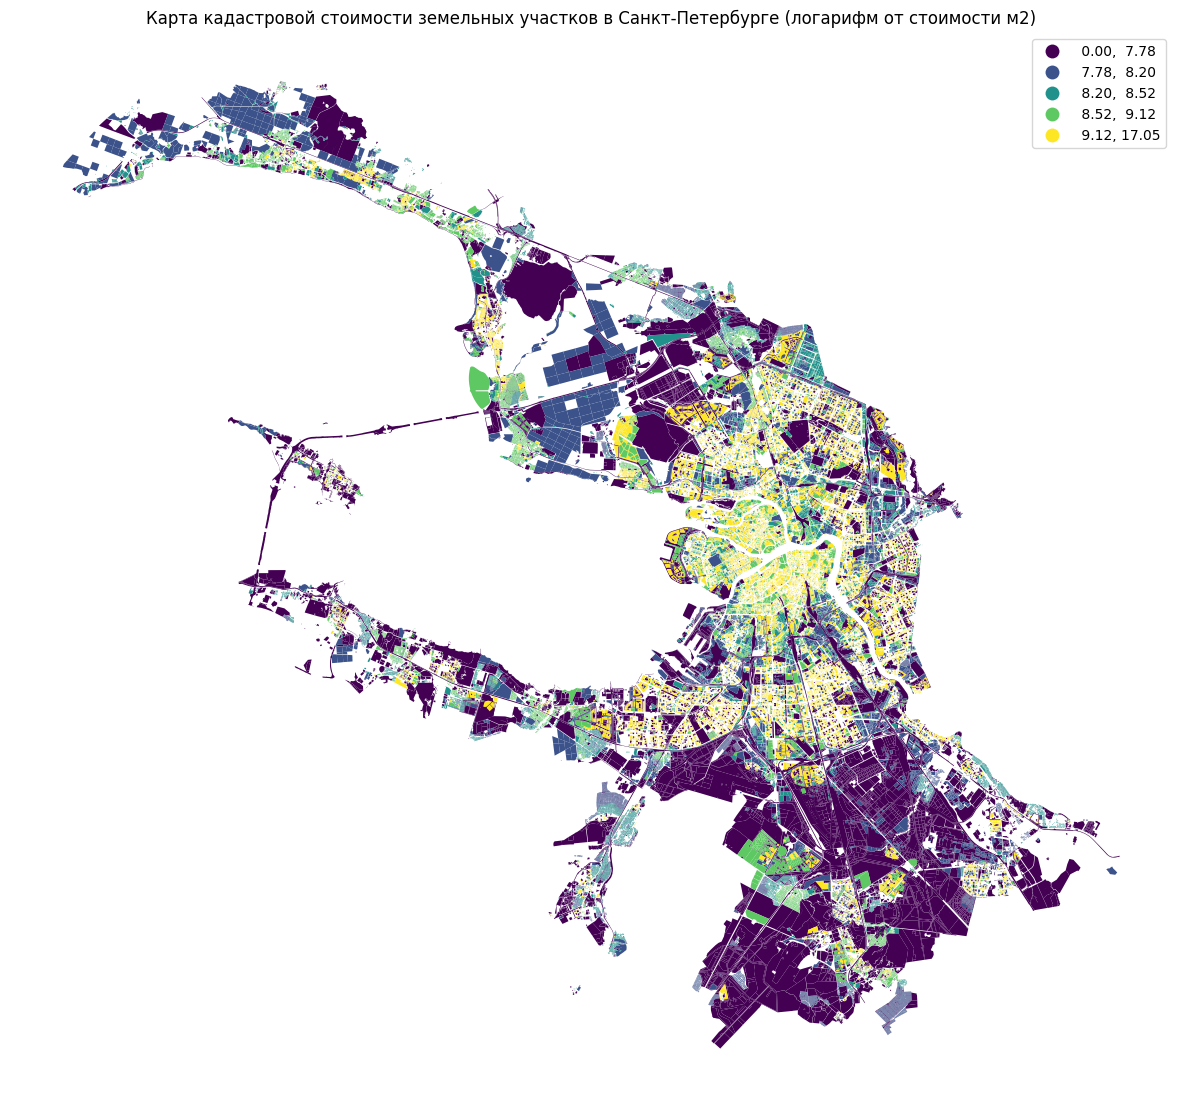

In [8]:
# Картируем лог-цену
cadastr_blocks.plot(
    column='log_cost_index',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Карта кадастровой стоимости земельных участков в Санкт-Петербурге (логарифм от стоимости м2)')

plt.show()

In [9]:
import geopandas as gpd

# — 1. Клонируем оригиналы, чтобы не портить исходники
blocks = blocks_gdf.copy()
cad    = cadastr_blocks.copy()

# — 2. Приводим к единому CRS (он нужен для корректных площадей)
if blocks.crs != cad.crs:
    cad = cad.to_crs(blocks.crs)

# — 3. Считаем полную площадь cadastral-полигонов
cad['cad_area'] = cad.geometry.area

# — 4. Явно добавляем в blocks колонку block_id из индекса
blocks['block_id'] = blocks.index

# — 5. Пересечение кварталов и кадастра
inter = gpd.overlay(
    blocks[['block_id', 'geometry']],
    cad   [['cost_value', 'cad_area', 'geometry']],
    how='intersection'
)

# — 6. Площадь каждого куска пересечения
inter['int_area'] = inter.geometry.area

# — 7. Вклады стоимости пропорционально площади
inter['cost_contrib'] = inter['cost_value'] * inter['int_area'] / inter['cad_area']

# — 8. Суммируем для каждого квартала
block_costs = (
    inter
    .groupby('block_id', as_index=False)['cost_contrib']
    .sum()
    .rename(columns={'cost_contrib':'total_cost_value'})
)

# — 9. Мерджим обратно в blocks, заполняем пропуски нулями
blocks = blocks.merge(block_costs, on='block_id', how='left')
blocks['total_cost_value'] = blocks['total_cost_value'].fillna(0)

# — 10. При желании убираем служебный block_id (или возвращаем исходный индекс)
blocks = blocks.drop(columns=['block_id'])
blocks


,geometry,land_use,is_living,build_floor_area,living_demand,living_area,share_living,business_area,share_business,site_area,...,capacity_pier,capacity_animal_shelter,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse,capacity_machine_building_plant,log_population,total_cost_value
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,True,43840.686518,50.641057,30688.480678,2.199357,13152.205840,0.942581,8.044667e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.408529,7.414402e+08
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",transport,True,10294.395525,53.114392,2177.690063,0.431105,8116.705462,1.606820,2.317313e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.737670,2.699018e+07
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",recreation,True,1173.871643,58.693582,821.710142,0.706252,352.161501,0.302679,3.630058e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.708050,2.995869e+08
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",residential,True,46303.954706,52.660044,30595.485797,2.760046,15708.468909,1.417075,1.964145e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.366470,6.688507e+08
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",recreation,True,153749.574111,53.097680,106407.750936,2.352959,47341.823175,1.046854,1.781752e+06,...,50.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,7.603399,9.278002e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16315,"POLYGON ((335210.252 6655823.328, 335105.217 6...",transport,False,0.000000,NaN,0.000000,NaN,0.000000,NaN,6.477731e+03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8.546459e+06
16316,"POLYGON ((315582.435 6679561.357, 315523.467 6...",transport,False,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.211677e+03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.389149e+06
16317,"POLYGON ((316419.909 6679189.653, 316319.749 6...",transport,False,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.835190e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.103986e+07
16318,"POLYGON ((315709.232 6679519.841, 315748.877 6...",transport,False,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.592307e+03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.825529e+06


In [10]:
# 1. Если CRS географический (deg), переведём в метрический (например, Меркатор)
if blocks.crs.is_geographic:
    blocks = blocks.to_crs(epsg=3857)

# 2. Считаем площадь каждого квартала в м²
blocks['area_sqm'] = blocks.geometry.area

# 3. Считаем цену за квадратный метр
blocks['price_per_sqm'] = blocks['total_cost_value'] / blocks['area_sqm']

# 4. (Опционально) уберём бесконечные и NaN
blocks.loc[~blocks['price_per_sqm'].replace([np.inf, -np.inf], np.nan).notna(), 'price_per_sqm'] = 0
blocks = blocks.to_crs(epsg=32636)
blocks.head()
# Результат: в blocks['price_per_sqm'] — стоимость одного квадрата метра для каждого квартала


,geometry,land_use,is_living,build_floor_area,living_demand,living_area,share_living,business_area,share_business,site_area,...,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse,capacity_machine_building_plant,log_population,total_cost_value,area_sqm,price_per_sqm
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,True,43840.686518,50.641057,30688.480678,2.199357,13152.205840,0.942581,8.044667e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,6.408529,7.414402e+08,8.044667e+05,921.654306
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",transport,True,10294.395525,53.114392,2177.690063,0.431105,8116.705462,1.606820,2.317313e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,3.737670,2.699018e+07,2.317313e+04,1164.718608
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",recreation,True,1173.871643,58.693582,821.710142,0.706252,352.161501,0.302679,3.630058e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,2.708050,2.995869e+08,3.630058e+05,825.295138
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",residential,True,46303.954706,52.660044,30595.485797,2.760046,15708.468909,1.417075,1.964145e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,6.366470,6.688507e+08,1.964145e+05,3405.302611
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",recreation,True,153749.574111,53.097680,106407.750936,2.352959,47341.823175,1.046854,1.781752e+06,...,0.0,0.0,30.0,0.0,0.0,0.0,7.603399,9.278002e+08,1.781752e+06,520.723685


In [11]:
blocks['log_total_price'] = np.log1p(blocks['total_cost_value'])
blocks['log_price'] = np.log1p(blocks['price_per_sqm'])

count    16320.000000
mean        10.941086
std          8.642160
min          0.000000
25%          0.000000
50%         14.701470
75%         18.558323
max         24.163684
Name: log_total_price, dtype: float64


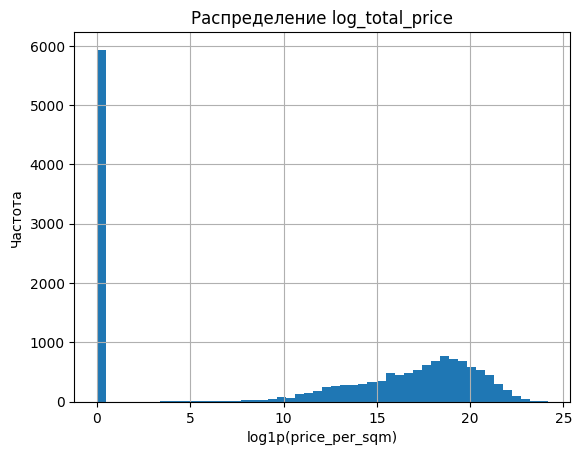

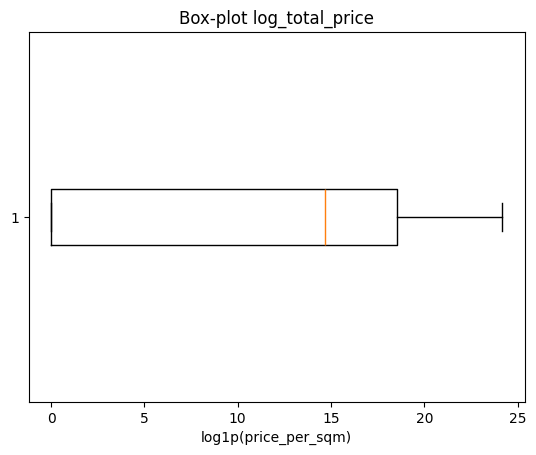

In [12]:
# Быстрая статистика
print(blocks['log_total_price'].describe())

# Гистограмма
plt.figure()
blocks['log_total_price'].hist(bins=50)
plt.xlabel('log1p(price_per_sqm)')
plt.ylabel('Частота')
plt.title('Распределение log_total_price')
plt.show()

# Box-plot
plt.figure()
plt.boxplot(blocks['log_total_price'].dropna(), vert=False)
plt.xlabel('log1p(price_per_sqm)')
plt.title('Box-plot log_total_price')
plt.show()


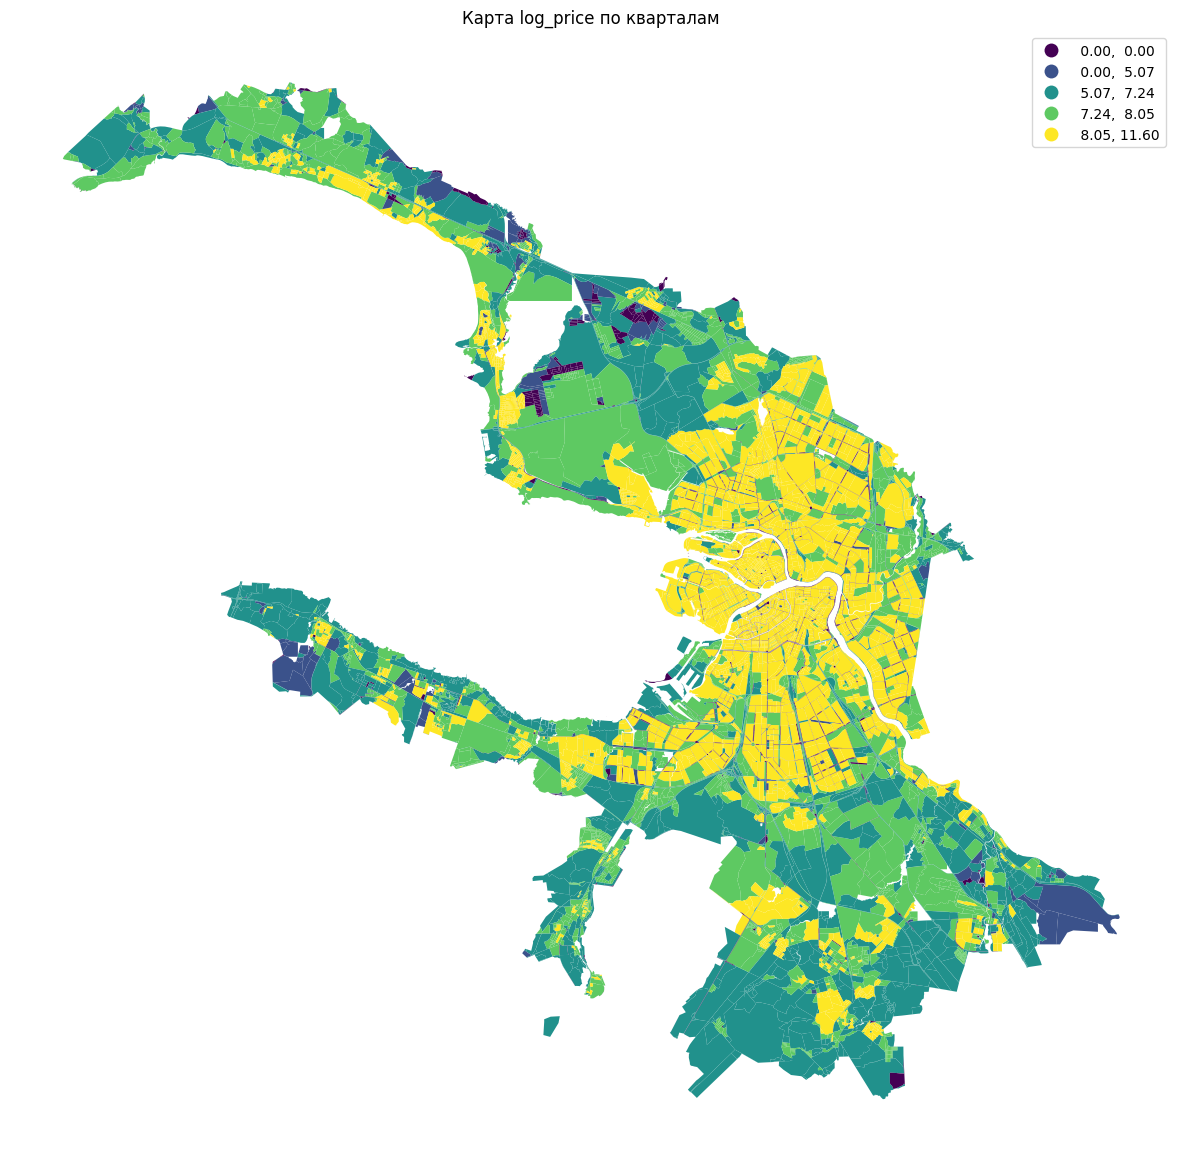

In [13]:
# Картируем лог-цену
blocks.plot(
    column='log_price',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Карта log_price по кварталам')

plt.show()



In [14]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# blocks['log_std'] = scaler.fit_transform(
#     blocks[['log_price']]
# )

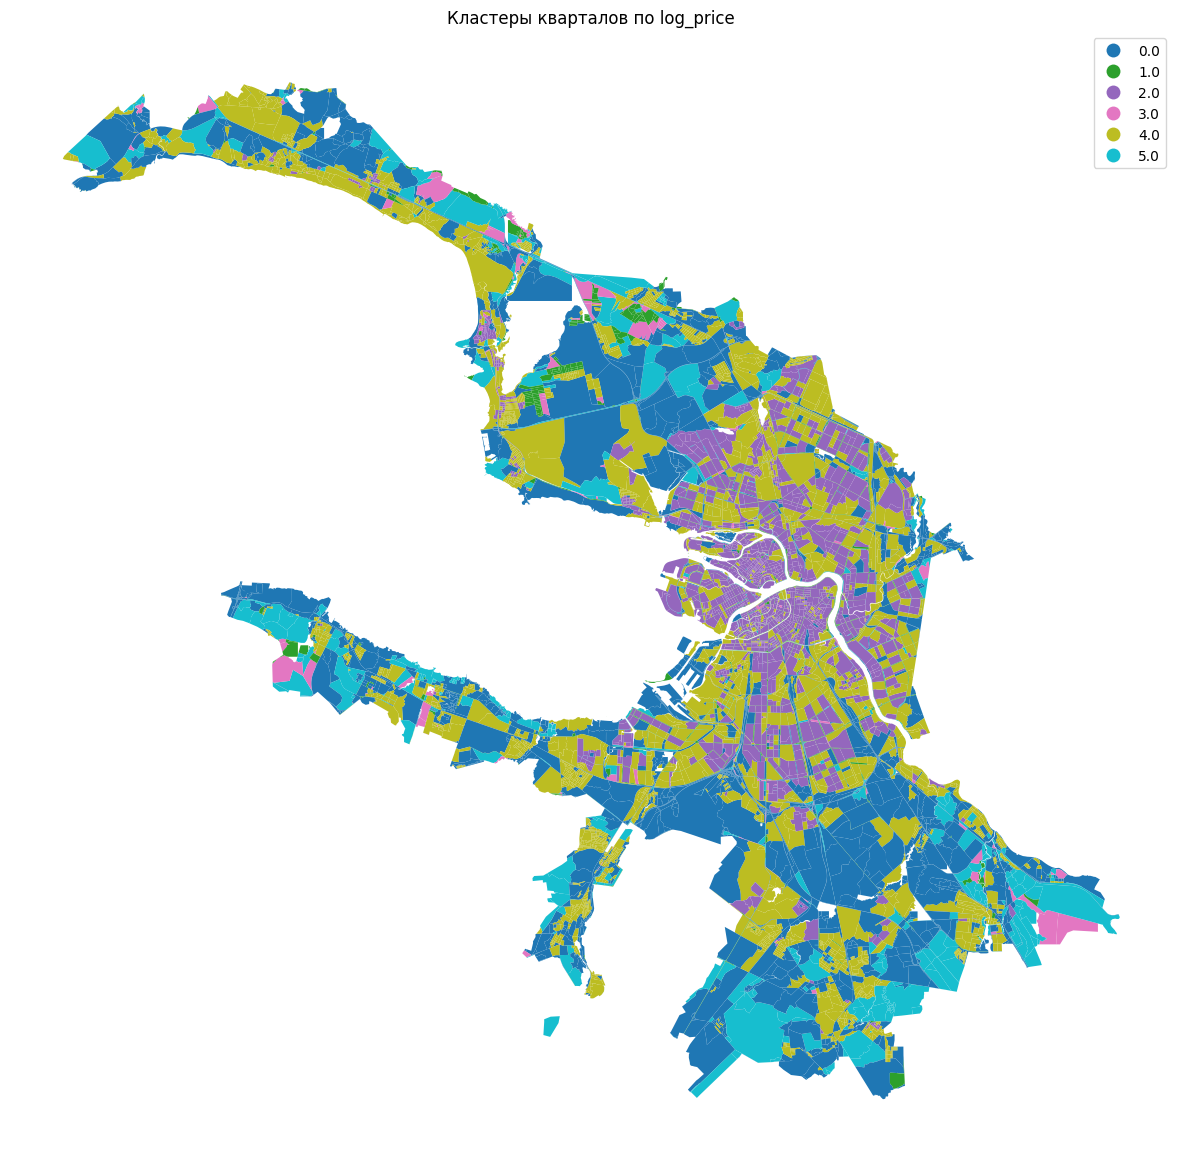

In [15]:
from sklearn.cluster import KMeans

# Берём только ненулевые и не NaN
X = blocks[['log_price']].dropna()

kmeans = KMeans(n_clusters=6, random_state=0)
blocks.loc[X.index, 'cluster'] = kmeans.fit_predict(X)

# Визуализируем
blocks.plot(
    column='cluster',
    categorical=True,
    legend=True,
    figsize=(15,15)
).set_axis_off()
plt.title('Кластеры кварталов по log_price')
plt.show()


In [16]:
# Собираем все имена колонок, которые начинаются на 'capacity'
cols_to_drop = [col for col in blocks.columns if col.startswith('capacity')]

# Удаляем их сразу все
blocks = blocks.drop(columns=cols_to_drop)
blocks.columns

Index(['geometry', 'land_use', 'is_living', 'build_floor_area',
       'living_demand', 'living_area', 'share_living', 'business_area',
       'share_business', 'site_area', 'population', 'footprint_area', 'fsi',
       'gsi', 'l', 'osr', 'mxi', 'log_population', 'total_cost_value',
       'area_sqm', 'price_per_sqm', 'log_total_price', 'log_price', 'cluster'],
      dtype='object')

## Дополнитльные метрики

In [17]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks)

2025-05-29 13:52:38.189 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:10 - Generating nodes
2025-05-29 13:52:38.195 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:15 - Generating edges
2025-05-29 13:52:40.406 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:38 - Adjacency graph successfully generated: 16320 nodes, 53425 edges


In [18]:
from blocksnet.analysis.centrality import population_centrality

centrality_df = population_centrality(blocks_gdf, adjacency_graph)
centrality_df.head()

,population,degree_centrality,population_normalized,degree_centrality_normalized,population_centrality
0,606,0.000429,1.019320,1.162791,0.091114
1,41,0.000613,1.001307,1.232558,0.115171
2,14,0.000490,1.000446,1.186047,0.091764
3,581,0.000490,1.018523,1.186047,0.102308
4,2004,0.000980,1.063889,1.372093,0.226121


In [19]:
df_to_merge = centrality_df.drop(columns=['population'])

In [20]:
blocks = blocks.join(df_to_merge)

In [21]:
import pandas as pd

accessibility_matrix = pd.read_pickle('data/accessibility_matrix.pickle')
accessibility_matrix.head()

/Users/mvin/Code/blocksnet/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,16310,16311,16312,16313,16314,16315,16316,16317,16318,16319
0,0.000000,18.718750,9.234375,17.21875,30.296875,27.390625,30.671875,23.281250,78.6875,81.2500,...,76.5625,102.5625,97.5000,132.250,130.8750,142.125,247.625,228.625,247.625,124.6250
1,17.859375,0.000000,19.015625,7.65625,20.281250,25.250000,25.234375,15.765625,76.8750,79.4375,...,74.6875,100.7500,95.6875,130.500,129.0000,140.250,245.875,226.875,245.875,112.5000
2,9.234375,20.796875,0.000000,20.21875,27.968750,25.062500,28.343750,20.953125,71.8750,74.4375,...,69.7500,95.8125,90.6875,125.500,124.0625,135.375,240.875,221.875,240.875,124.6250
3,15.937500,7.449219,18.421875,0.00000,21.109375,24.984375,27.781250,16.593750,76.3125,78.8125,...,74.1250,100.1875,95.0625,129.875,128.5000,139.750,245.250,226.250,245.250,113.3750
4,31.906250,19.765625,31.734375,21.28125,0.000000,21.781250,23.125000,15.429688,89.5625,92.1250,...,87.4375,113.5000,108.3750,143.125,141.7500,153.000,258.500,239.500,258.500,108.3125


In [22]:
from blocksnet.analysis.accessibility import area_accessibility

area_acc_df = area_accessibility(accessibility_matrix, blocks_gdf)
area_acc_df

,area_accessibility
0,113.515315
1,109.100728
2,108.464070
3,109.170690
4,119.413257
...,...
16315,126.334338
16316,198.099430
16317,186.754339
16318,198.099430


In [23]:
blocks= blocks.join(area_acc_df)


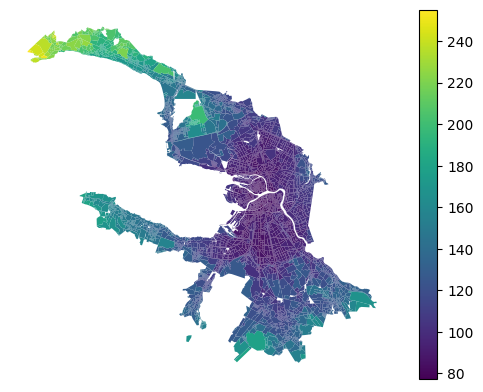

In [24]:
blocks.plot(column='area_accessibility', legend=True).set_axis_off()

In [25]:
blocks.columns

Index(['geometry', 'land_use', 'is_living', 'build_floor_area',
       'living_demand', 'living_area', 'share_living', 'business_area',
       'share_business', 'site_area', 'population', 'footprint_area', 'fsi',
       'gsi', 'l', 'osr', 'mxi', 'log_population', 'total_cost_value',
       'area_sqm', 'price_per_sqm', 'log_total_price', 'log_price', 'cluster',
       'degree_centrality', 'population_normalized',
       'degree_centrality_normalized', 'population_centrality',
       'area_accessibility'],
      dtype='object')

In [26]:
blocks = blocks.drop(columns='cluster')

In [27]:
# 1. Выведем все dtypes
print(blocks.dtypes)

# 2. Отберём «чисто» категориальные (object / category)
cat_cols = blocks.select_dtypes(include=['object','category']).columns.tolist()
print("Категориальные по dtype:", cat_cols)

# 3. Часто к категориальным относят и числовые колонки с малым числом уникальных значений.
#    Например, если уникальных значений меньше 10:
low_cardinality = [
    col for col in blocks.select_dtypes(include=['int64','float64']).columns
    if blocks[col].nunique() < 10
]
print("Возможно категориальные по низкой кардинальности:", low_cardinality)


geometry                        geometry
land_use                          object
is_living                           bool
build_floor_area                 float64
living_demand                    float64
living_area                      float64
share_living                     float64
business_area                    float64
share_business                   float64
site_area                        float64
population                         int64
footprint_area                   float64
fsi                              float64
gsi                              float64
l                                float64
osr                              float64
mxi                              float64
log_population                   float64
total_cost_value                 float64
area_sqm                         float64
price_per_sqm                    float64
log_total_price                  float64
log_price                        float64
degree_centrality                float64
population_norma

In [28]:
import pandas as pd

# 1. Отбираем числовые столбцы и фильтруем
num = blocks.select_dtypes(include=['number'])
num = num[num['log_price'] > 1]

# 2. Считаем count + статистики
agg_stats = num.agg(['count', 'min', 'max', 'mean', 'median', 'std']).T

# 3. Переименовываем столбцы
agg_stats.index.name = 'Variable'
agg_stats = agg_stats.rename(columns={
    'count':  'Count',
    'min':    'Min',
    'max':    'Max',
    'mean':   'Mean',
    'median': 'Median',
    'std':    'SD'
})

# 4. Приводим Count к int
agg_stats['Count'] = agg_stats['Count'].astype(int)

# 5. Округляем остальные метрики
for col in ['Min','Max','Mean','Median','SD']:
    agg_stats[col] = agg_stats[col].round(2)

# 6. Настраиваем глобальный формат для float
pd.options.display.float_format = '{:,.2f}'.format

# 7. Показываем результат
agg_stats


,Count,Min,Max,Mean,Median,SD
Variable,,,,,,
build_floor_area,10303,0.00,"1,659,527.76","38,306.64",878.68,"106,895.10"
living_demand,4548,0.00,561.19,43.76,32.66,31.90
living_area,10303,0.00,"658,793.14","16,413.36",0.00,"55,527.78"
share_living,6013,0.00,21.02,1.22,0.70,1.70
business_area,10303,0.00,"1,659,527.76","21,893.28",446.53,"63,030.60"
share_business,6013,0.11,65.22,1.54,1.01,1.63
site_area,10303,1.07,"16,147,809.90","129,144.01","21,660.70","457,248.04"
population,10303,0.00,"31,367.00",524.37,0.00,"1,929.06"
footprint_area,10303,0.00,"757,715.64","9,991.32",755.65,"25,029.45"


# CatBoost

0:	learn: 8.5853082	test: 8.6083242	best: 8.6083242 (0)	total: 1.73ms	remaining: 1.72s
100:	learn: 5.8618009	test: 5.8382874	best: 5.8382874 (100)	total: 131ms	remaining: 1.16s
200:	learn: 5.2760796	test: 5.2449799	best: 5.2449799 (200)	total: 298ms	remaining: 1.19s
300:	learn: 5.1206490	test: 5.0958727	best: 5.0958727 (300)	total: 428ms	remaining: 994ms
400:	learn: 5.0674912	test: 5.0472454	best: 5.0472454 (400)	total: 546ms	remaining: 816ms
500:	learn: 5.0384108	test: 5.0219915	best: 5.0219915 (500)	total: 675ms	remaining: 672ms
600:	learn: 5.0186534	test: 5.0060758	best: 5.0060758 (600)	total: 792ms	remaining: 526ms
700:	learn: 5.0027515	test: 4.9932132	best: 4.9932132 (700)	total: 930ms	remaining: 397ms
800:	learn: 4.9893403	test: 4.9837441	best: 4.9837441 (800)	total: 1.06s	remaining: 263ms
900:	learn: 4.9764748	test: 4.9740838	best: 4.9740838 (900)	total: 1.16s	remaining: 128ms
999:	learn: 4.9633981	test: 4.9641789	best: 4.9641789 (999)	total: 1.33s	remaining: 0us

bestTest = 4.9

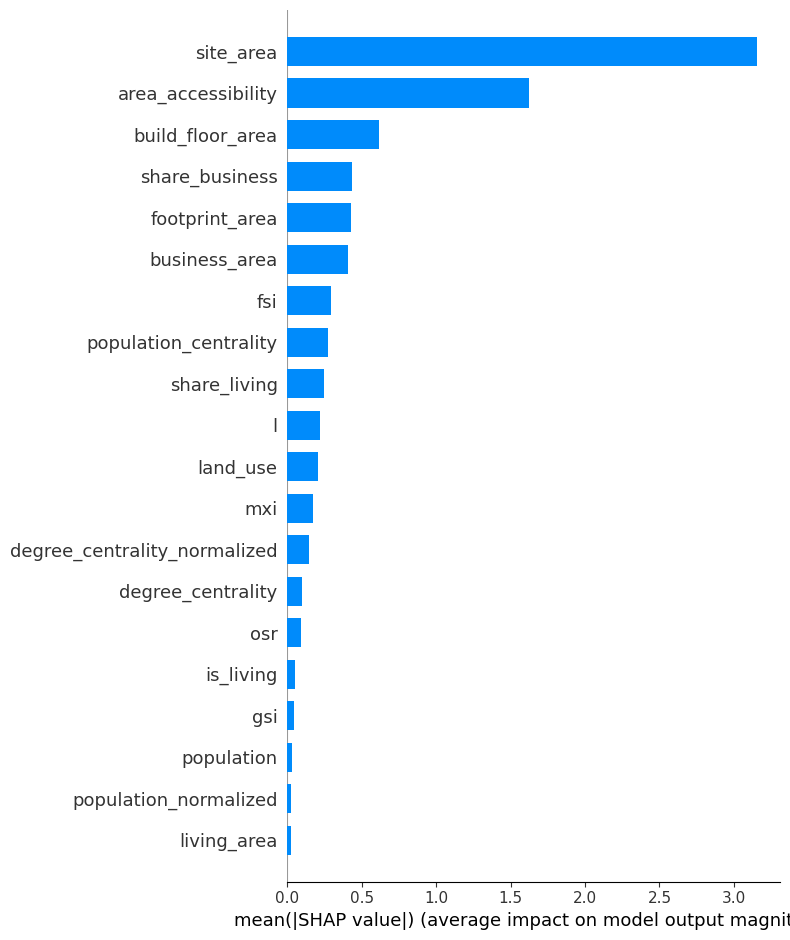

<Figure size 640x480 with 0 Axes>

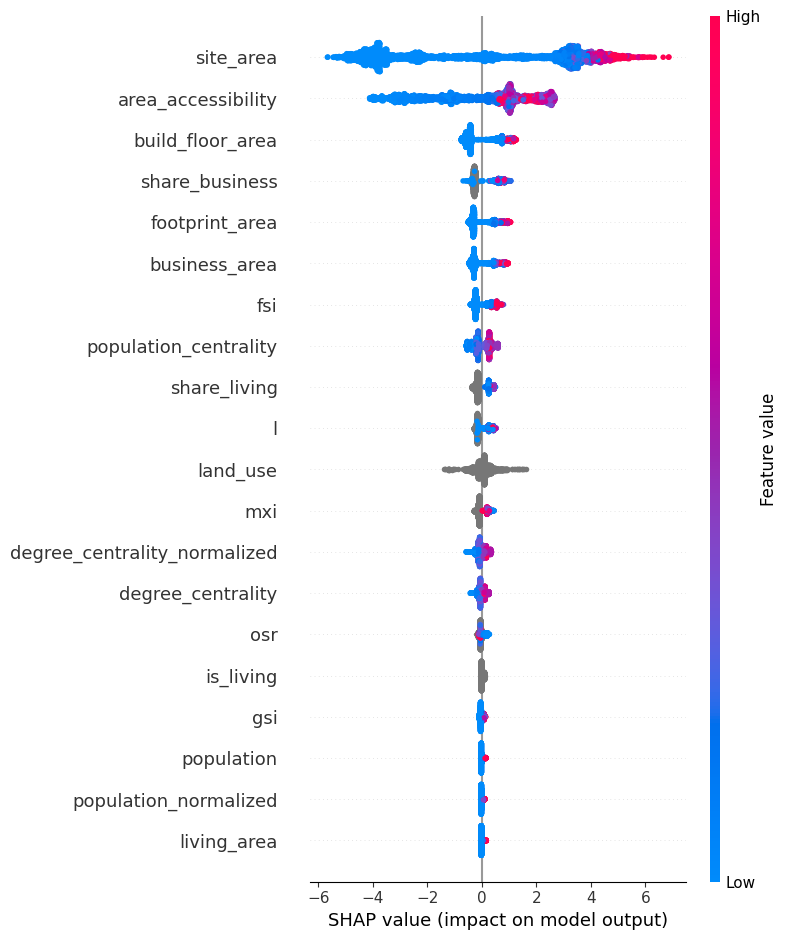

<Figure size 640x480 with 0 Axes>

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt

# --- 1. Исходные данные ---
# blocks — ваш GeoDataFrame с колонкой log_price.

feature_cols = [
    'land_use', 'is_living',
    'build_floor_area', 'living_demand', 'living_area', 'share_living',
    'business_area', 'share_business', 'site_area', 'population',
    'footprint_area', 'fsi', 'gsi', 'l', 'osr', 'mxi',
    'area_accessibility', 'degree_centrality',
    'population_normalized', 'degree_centrality_normalized',
    'population_centrality'
]
X = blocks[feature_cols].copy()
y = blocks['log_total_price'].copy()

# --- 2. Сплит на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 3. Предобработка категорий ---
cat_features = ['land_use', 'is_living']

for df in (X_train, X_test):
    # 3.1 land_use — строковая категория
    df['land_use'] = df['land_use'].fillna('missing').astype(str).astype('category')
    # 3.2 is_living — булево, заменим пропуски на False и переведём в категорию
    df['is_living'] = df['is_living'].fillna(False).astype('bool').astype('category')

# Если хотите передавать индексы вместо имён:
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_features]

# --- 4. Создаём Pool ---
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
test_pool  = Pool(data=X_test,  label=y_test,  cat_features=cat_feature_indices)

# --- 5. Обучаем модель ---
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=3,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

# --- 6. Метрики на test ---
y_pred = model.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# --- 7. SHAP-анализ ---
explainer    = shap.TreeExplainer(model)
shap_values  = explainer.shap_values(X_test)

# 7.1 Глобальная важность — столбчатая
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.show()

# 7.2 Beeswarm-plot
shap.summary_plot(shap_values, X_test)
plt.tight_layout()
plt.show()



# XGBoost

In [70]:
# 0. Библиотеки
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from xgboost import XGBRegressor


# 1. Фильтрация

# 2. Признаки и целевая (в исходной шкале)
feature_cols = [
    'land_use', 'is_living',
    'build_floor_area', 'living_demand', 'living_area', 'share_living',
    'business_area', 'share_business', 'site_area', 'population',
    'footprint_area', 'fsi', 'gsi', 'l', 'osr', 'mxi',
    'area_accessibility', 'degree_centrality',
    'population_normalized', 'degree_centrality_normalized',
    'population_centrality'
]
X = blocks[feature_cols].copy()

# если у вас есть колонка 'price', используйте её,
# иначе восстанавливаем из логарифма:
y = np.expm1(blocks['log_total_price'])

cat_feats = ['land_use', 'is_living']
num_feats = [c for c in feature_cols if c not in cat_feats]

# 3. Стратифицированный сплит по квантилям log_price
y_bins = pd.qcut(blocks['log_total_price'], q=10, labels=False, duplicates='drop')
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y_bins
)

# 4. Препроцессор
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 5. XGB для отбора признаков
xgb_fs = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=1,
    reg_lambda=5,
    random_state=42,
    n_jobs=-1
)

selector = SelectFromModel(
    estimator=xgb_fs,
    threshold='median'    # можно изменить на 'mean' или конкретное значение,
                          # чтобы оставлять ровно ~50% самых важных признаков
)

# 6. Финальный XGB внутри TransformedTargetRegressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
ttr = TransformedTargetRegressor(
    regressor=xgb_model,
    func=np.log1p,
    inverse_func=np.expm1
)

pipe = Pipeline([
    ('prep',   preproc),
    ('select', selector),
    ('model',  ttr)
])

from sklearn.model_selection import RandomizedSearchCV

# 7. Случайный поиск по гиперпараметрам
param_dist = {
    'model__regressor__n_estimators':     [500, 800, 1000],
    'model__regressor__learning_rate':    [0.05, 0.1, 0.2],
    'model__regressor__max_depth':        [4, 6],
    'model__regressor__subsample':        [0.8, 0.9, 1.0],
    'model__regressor__colsample_bytree': [0.8, 0.9, 1.0],
    'model__regressor__reg_alpha':        [0, 1, 5],
    'model__regressor__reg_lambda':       [1, 5, 10],
}

rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=50,                            # число случайных комбинаций
    cv=4,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rs.fit(X_train, y_train)
best_model = rs.best_estimator_
print("Лучшие гиперпараметры:", rs.best_params_)

# 8. Прогнозы на train и hold-out
y_pred_train = best_model.predict(X_train)
y_pred_hold  = best_model.predict(X_hold)


def nrmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (y_true.max() - y_true.min())

metrics = {
    'R²'   : (r2_score(y_train,      y_pred_train),
              r2_score(y_hold,       y_pred_hold)),
    'MAPE' : (mean_absolute_percentage_error(y_train, y_pred_train),
              mean_absolute_percentage_error(y_hold,  y_pred_hold)),
    'nRMSE': (nrmse(y_train,          y_pred_train),
              nrmse(y_hold,           y_pred_hold))
}

print('\n=== TRAIN | HOLD-OUT ===')
for m,(tr,val) in metrics.items():
    print(f'{m:5}: {tr:8.3f} | {val:8.3f}')




Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] END model__regressor__colsample_bytree=1.0, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=500, model__regressor__reg_alpha=5, model__regressor__reg_lambda=10, model__regressor__subsample=0.8; total time=   2.6s
[CV] END model__regressor__colsample_bytree=1.0, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=500, model__regressor__reg_alpha=5, model__regressor__reg_lambda=10, model__regressor__subsample=0.8; total time=   2.7s
[CV] END model__regressor__colsample_bytree=0.9, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=500, model__regressor__reg_alpha=5, model__regressor__reg_lambda=10, model__regressor__subsample=1.0; total time=   3.0s
[CV] END model__regressor__colsample_bytree=1.0, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regress

# PyTorch 

In [ ]:
from blocksnet.relations import generate_adjacency_graph

graph = generate_adjacency_graph(blocks, 10)
for block_id in graph.neighbors(1):
    print(block_id)

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ---------------------------
# 1) Фичи и преобработка
# ---------------------------

feature_cols = [
    'land_use', 'is_living',
    'build_floor_area','living_demand','living_area','share_living',
    'business_area','share_business','site_area','population',
    'footprint_area','fsi','gsi','l','osr','mxi',
    'area_accessibility','degree_centrality',
    'population_normalized','degree_centrality_normalized',
    'population_centrality'
]

# One-hot кодирование land_use
land_dummies = pd.get_dummies(blocks['land_use'], prefix='land_use')
blocks['is_living'] = blocks['is_living'].astype(int)

# Собираем DataFrame признаков
X_df = pd.concat([
    land_dummies,
    blocks.drop(columns=['land_use', 'geometry'])[
        [c for c in feature_cols if c != 'land_use']
    ]
], axis=1)

# Импутация и стандартизация
X = X_df.values.astype(np.float64)
X[np.isinf(X)] = np.nan
X = SimpleImputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X).astype(np.float32)

# Целевая переменная
y = blocks['log_total_price'].values.astype(np.float32)

# ---------------------------
# 2) Train / Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Преобразуем в тензоры и DataLoader
batch_size = 64
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# ---------------------------
# 3) Определение DNN-регрессора
# ---------------------------
class DNNRegressor(torch.nn.Module):
    def __init__(self, in_features, hidden_layers=[256, 128, 64], dropout=0.3):
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden_layers:
            layers.append(torch.nn.Linear(prev, h))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout))
            prev = h
        layers.append(torch.nn.Linear(prev, 1))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DNNRegressor(in_features=X.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

# ---------------------------
# 4) Функции обучения и оценки
# ---------------------------
def train_epoch():
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    y_true = []
    y_pred = []
    for xb, yb in loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.append(preds)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return {
        'r2'  : r2_score(y_true, y_pred),
        'mae' : mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
    }

# ---------------------------
# 5) Цикл обучения
# ---------------------------
n_epochs = 350
for epoch in range(1, n_epochs+1):
    loss = train_epoch()
    if epoch % 10 == 0 or epoch == 1:
        train_metrics = evaluate(train_loader)
        test_metrics  = evaluate(test_loader)
        print(f"Epoch {epoch:03d} | Loss {loss:.4f} | "
              f"Train R² {train_metrics['r2']:.3f}, MAE {train_metrics['mae']:.3f}, RMSE {train_metrics['rmse']:.3f} | "
              f"Test  R² {test_metrics['r2']:.3f}, MAE {test_metrics['mae']:.3f}, RMSE {test_metrics['rmse']:.3f}")

# Финальные метрики на тесте
final_metrics = evaluate(test_loader)
print("\n=== Final Test Metrics ===")
print(f"R²   = {final_metrics['r2']:.4f}")
print(f"MAE  = {final_metrics['mae']:.4f}")
print(f"RMSE = {final_metrics['rmse']:.4f}")


Epoch 001 | Loss 57.1057 | Train R² 0.534, MAE 4.968, RMSE 5.894 | Test  R² 0.539, MAE 4.922, RMSE 5.881
Epoch 010 | Loss 31.6323 | Train R² 0.627, MAE 4.077, RMSE 5.273 | Test  R² 0.640, MAE 4.022, RMSE 5.197
Epoch 020 | Loss 30.4496 | Train R² 0.635, MAE 4.015, RMSE 5.218 | Test  R² 0.648, MAE 3.956, RMSE 5.141
Epoch 030 | Loss 29.6313 | Train R² 0.645, MAE 4.019, RMSE 5.149 | Test  R² 0.654, MAE 3.980, RMSE 5.096
Epoch 040 | Loss 28.6289 | Train R² 0.638, MAE 4.162, RMSE 5.196 | Test  R² 0.642, MAE 4.152, RMSE 5.182
Epoch 050 | Loss 27.9063 | Train R² 0.661, MAE 3.658, RMSE 5.031 | Test  R² 0.668, MAE 3.616, RMSE 4.991
Epoch 060 | Loss 27.5214 | Train R² 0.671, MAE 3.602, RMSE 4.957 | Test  R² 0.676, MAE 3.597, RMSE 4.933
Epoch 070 | Loss 26.9855 | Train R² 0.673, MAE 3.594, RMSE 4.936 | Test  R² 0.675, MAE 3.582, RMSE 4.935
Epoch 080 | Loss 26.9894 | Train R² 0.678, MAE 3.581, RMSE 4.904 | Test  R² 0.677, MAE 3.579, RMSE 4.919
Epoch 090 | Loss 26.5650 | Train R² 0.674, MAE 3.652, R

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ---------------------------
# 0) Настройки устройства
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------------------
# 1) Фичи и предобработка (включая one-hot для land_use)
# ---------------------------
feature_cols = [
    'land_use', 'is_living',
    'build_floor_area','living_demand','living_area','share_living',
    'business_area','share_business','site_area','population',
    'footprint_area','fsi','gsi','l','osr','mxi',
    'area_accessibility','degree_centrality',
    'population_normalized','degree_centrality_normalized',
    'population_centrality'
]

# One-hot кодирование land_use
land_dummies = pd.get_dummies(blocks['land_use'], prefix='land_use')
blocks['is_living'] = blocks['is_living'].astype(int)

# Собираем DataFrame фичей
X_df = pd.concat([
    land_dummies,
    blocks.drop(columns=['land_use', 'geometry'])[
        [c for c in feature_cols if c != 'land_use']
    ]
], axis=1)

# Сохраняем порядок колонок для последующего реиндекса
cols_train = X_df.columns

# Переводим в массив и очищаем inf → NaN
X = X_df.values.astype(np.float64)
X[np.isinf(X)] = np.nan

# 2) Импутация и стандартизация на всём наборе
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype(np.float32)

# Целевая переменная
y = blocks['log_total_price'].values.astype(np.float32)

# ---------------------------
# 3) Train/Test split + DataLoader
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

batch_size = 64
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# ---------------------------
# 4) Определение DNN-регрессора
# ---------------------------
class DNNRegressor(torch.nn.Module):
    def __init__(self, in_features, hidden_layers=[128, 64, 32], dropout=0.3):
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden_layers:
            layers.append(torch.nn.Linear(prev, h))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout))
            prev = h
        layers.append(torch.nn.Linear(prev, 1))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        # возвращаем одномерный вектор
        return self.net(x).squeeze(1)

model = DNNRegressor(in_features=X_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

# ---------------------------
# 5) Функции обучения и оценки
# ---------------------------
def train_epoch():
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.append(preds)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return {
        'r2'  : r2_score(y_true, y_pred),
        'mae' : mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
    }

# ---------------------------
# 6) Цикл обучения
# ---------------------------
n_epochs = 500
patience = 10           # сколько эпох ждать улучшения
best_loss = float('inf')
counter = 0

# путь для сохранения лучшей модели
best_model_path = 'best_model.pt'

train_r2s       = []
train_maes      = []
train_rmses     = []
test_r2s        = []
test_maes       = []
test_rmses      = []
eval_epochs = []
for epoch in range(1, n_epochs + 1):
    loss = train_epoch()
    # каждые 10 эпох (и в первой) считаем метрики на train/test
    if epoch % 10 == 0 or epoch == 1:
        eval_epochs.append(epoch)   
        tr = evaluate(train_loader)
        te = evaluate(test_loader)
        val_rmse = te['rmse']
        print(f"Epoch {epoch:03d} | Loss {loss:.4f} | "
              f"Train R² {tr['r2']:.3f}, MAE {tr['mae']:.3f}, RMSE {tr['rmse']:.3f} | "
              f"Test  R² {te['r2']:.3f}, MAE {te['mae']:.3f}, RMSE {te['rmse']:.3f}")
        # логируем метрики
        train_r2s.append(tr['r2'])
        train_maes.append(tr['mae'])
        train_rmses.append(tr['rmse'])
        test_r2s.append(te['r2'])
        test_maes.append(te['mae'])
        test_rmses.append(te['rmse'])

        # проверяем улучшение
        if val_rmse < best_loss:
            best_loss = val_rmse
            counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"  → улучшение валидации, сохраняем модель (RMSE={best_loss:.4f})")
        else:
            counter += 1
            print(f"  → без улучшения {counter}/{patience}")
            if counter >= patience:
                print(f"\nEarly stopping! Нет улучшений в течение {patience} эпох.")
                # загружаем лучшую модель обратно
                model.load_state_dict(torch.load(best_model_path))
                break

# если досрочно не вышли — на всякий случай загрузим лучшую
else:
    model.load_state_dict(torch.load(best_model_path))

# Финальные метрики
final = evaluate(test_loader)
print("\n=== Final Test Metrics ===")
print(f"R²   = {final['r2']:.4f}")
print(f"MAE  = {final['mae']:.4f}")
print(f"RMSE = {final['rmse']:.4f}")

# ---------------------------
# 7) Инференс: предсказание для log_total_price == 0
# ---------------------------
mask_zero   = blocks['log_total_price'] == 0
blocks_zero = blocks[mask_zero].copy()

# Собираем фичи так же, но только для этих строк
land_dummies_zero = pd.get_dummies(blocks_zero['land_use'], prefix='land_use')
X_zero_df = pd.concat([
    land_dummies_zero,
    blocks_zero.drop(columns=['land_use', 'geometry'])[
        [c for c in feature_cols if c != 'land_use']
    ]
], axis=1)

# Реиндексация под колонки обучающего DataFrame
X_zero_df = X_zero_df.reindex(columns=cols_train, fill_value=0)

# Массив, очистка inf → NaN
X_zero = X_zero_df.values.astype(np.float64)
X_zero[np.isinf(X_zero)] = np.nan

# Импьютация и скейлинг
X_zero_imp    = imputer.transform(X_zero)
X_zero_scaled = scaler.transform(X_zero_imp).astype(np.float32)

# Предсказание и обрезка снизу (чтобы не было отрицательных)
model.eval()
with torch.no_grad():
    X_t       = torch.from_numpy(X_zero_scaled).to(device)
    preds_log = model(X_t).cpu().numpy()
    preds_log = np.clip(preds_log, a_min=0.0, a_max=None)

# Записываем в новый столбец
blocks.loc[mask_zero, 'log_total_price_pred'] = preds_log
blocks.loc[mask_zero, 'total_price_pred'] = np.expm1(preds_log)


Epoch 001 | Loss 66.7182 | Train R² 0.511, MAE 5.128, RMSE 6.037 | Test  R² 0.524, MAE 5.067, RMSE 5.973
  → улучшение валидации, сохраняем модель (RMSE=5.9730)
Epoch 010 | Loss 33.8512 | Train R² 0.620, MAE 4.024, RMSE 5.326 | Test  R² 0.632, MAE 3.965, RMSE 5.252
  → улучшение валидации, сохраняем модель (RMSE=5.2517)
Epoch 020 | Loss 32.3771 | Train R² 0.624, MAE 4.026, RMSE 5.296 | Test  R² 0.637, MAE 3.962, RMSE 5.220
  → улучшение валидации, сохраняем модель (RMSE=5.2197)
Epoch 030 | Loss 31.1226 | Train R² 0.630, MAE 4.124, RMSE 5.252 | Test  R² 0.641, MAE 4.069, RMSE 5.193
  → улучшение валидации, сохраняем модель (RMSE=5.1926)
Epoch 040 | Loss 30.0411 | Train R² 0.644, MAE 3.970, RMSE 5.155 | Test  R² 0.654, MAE 3.910, RMSE 5.097
  → улучшение валидации, сохраняем модель (RMSE=5.0972)
Epoch 050 | Loss 29.3721 | Train R² 0.652, MAE 3.884, RMSE 5.098 | Test  R² 0.660, MAE 3.840, RMSE 5.048
  → улучшение валидации, сохраняем модель (RMSE=5.0480)
Epoch 060 | Loss 29.1539 | Train R

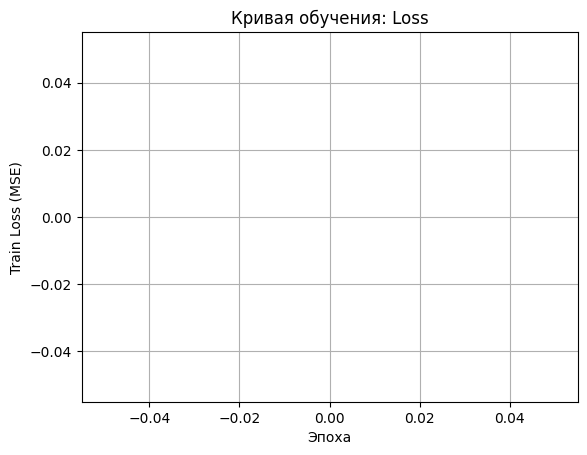

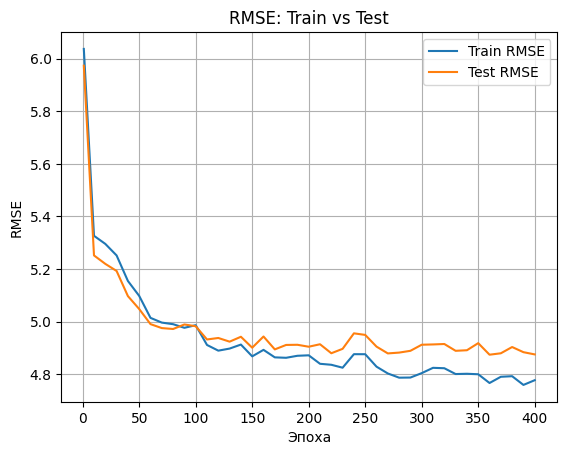

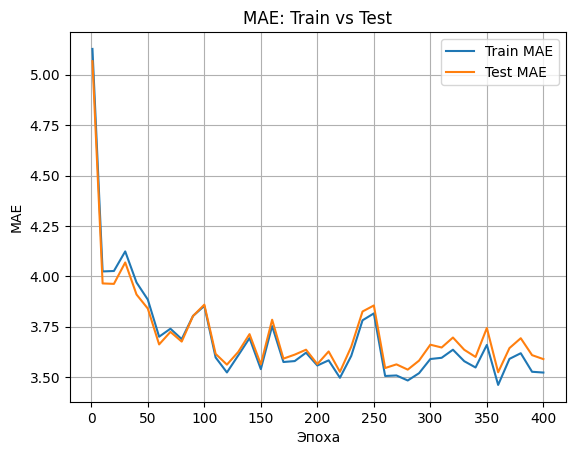

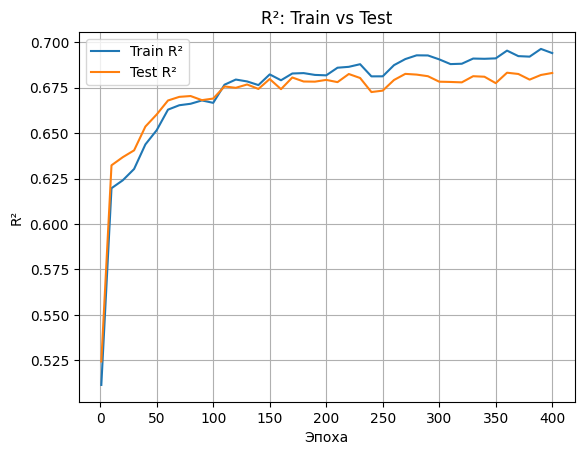

In [ ]:
import matplotlib.pyplot as plt

# # 1) Train Loss — здесь всё по train_losses и по эпохам 1…N
# plt.figure()
# plt.plot(range(1, len(train_losses) + 1), train_losses)
# plt.xlabel('Эпоха')
# plt.ylabel('Train Loss (MSE)')
# plt.title('Кривая обучения: Loss')
# plt.grid(True)
# plt.show()

# 2) RMSE на train vs test
plt.figure()
plt.plot(eval_epochs, train_rmses, label='Train RMSE')
plt.plot(eval_epochs, test_rmses,  label='Test RMSE')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.title('RMSE: Train vs Test')
plt.legend()
plt.grid(True)
plt.show()

# 3) MAE
plt.figure()
plt.plot(eval_epochs, train_maes, label='Train MAE')
plt.plot(eval_epochs, test_maes,  label='Test MAE')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.title('MAE: Train vs Test')
plt.legend()
plt.grid(True)
plt.show()

# 4) R²
plt.figure()
plt.plot(eval_epochs, train_r2s,  label='Train R²')
plt.plot(eval_epochs, test_r2s,   label='Test R²')
plt.xlabel('Эпоха')
plt.ylabel('R²')
plt.title('R²: Train vs Test')
plt.legend()
plt.grid(True)
plt.show()


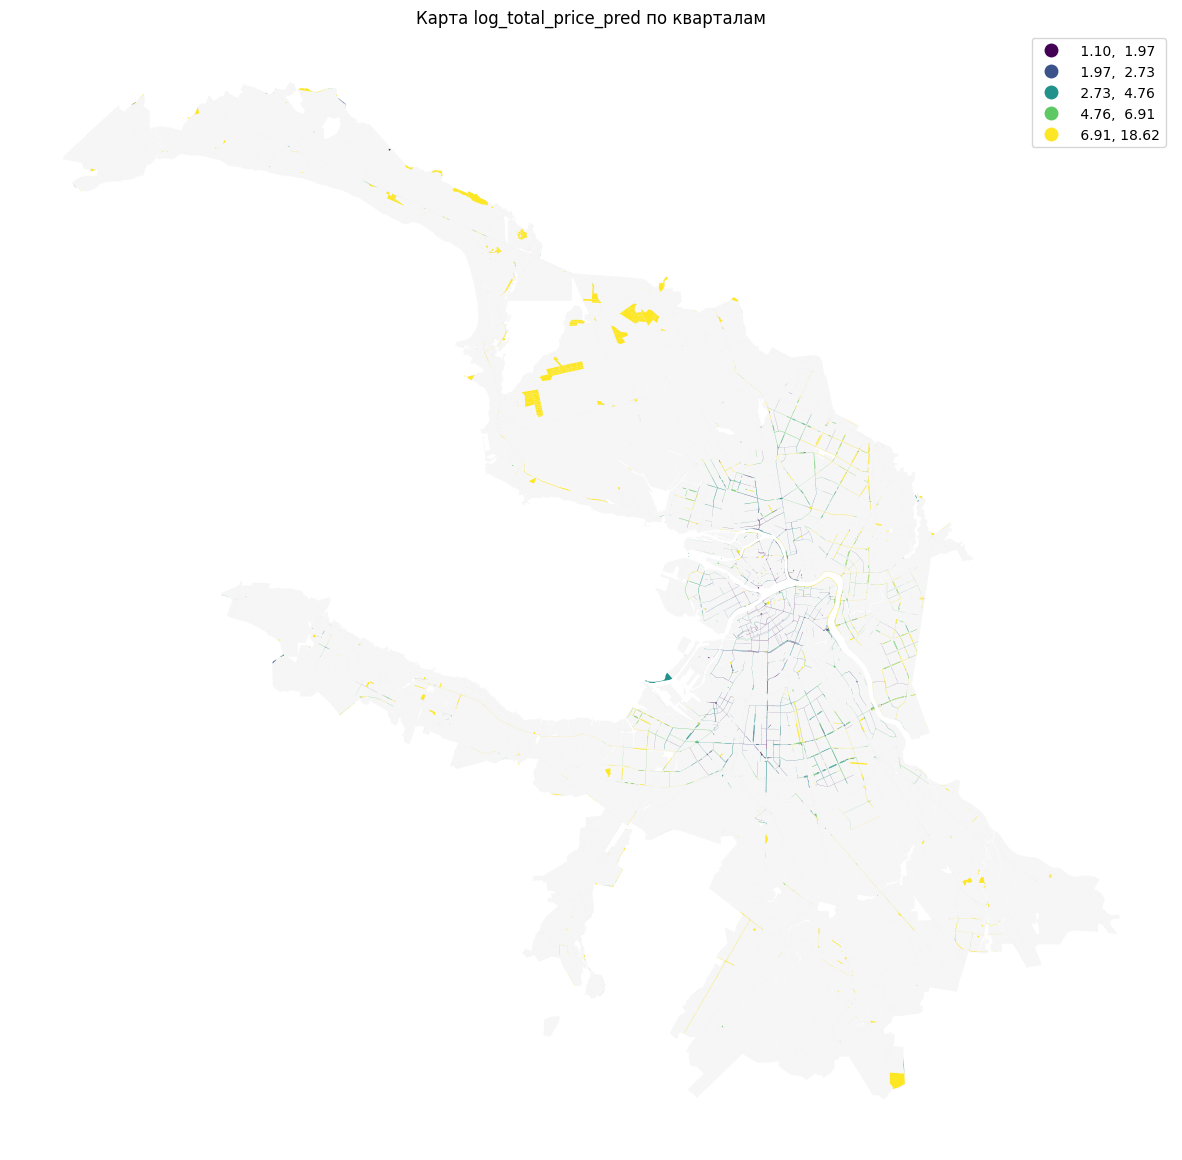

In [65]:
import matplotlib.pyplot as plt

# Создаём фигуру и ось
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# 1) Рисуем все кварталы серым цветом с прозрачностью 20%
blocks.geometry.plot(
    ax=ax,
    color='lightgray',
    edgecolor='none',
    alpha=0.2,
)

# 2) Слой с вашей картой log_total_price_pred
blocks.plot(
    column='log_total_price_pred',
    scheme='quantiles',
    legend=True,
    ax=ax,
    cmap='viridis'
)

# Убираем оси и ставим заголовок
ax.set_axis_off()
ax.set_title('Карта log_total_price_pred по кварталам')

plt.show()



# Деревья решений

Лучшие параметры DecisionTree: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
DT RMSE (log_price): 5.0164
DT RMSE (price_per_sqm): 635987249.64 RUB/m²
DT R² (price_per_sqm): 0.436


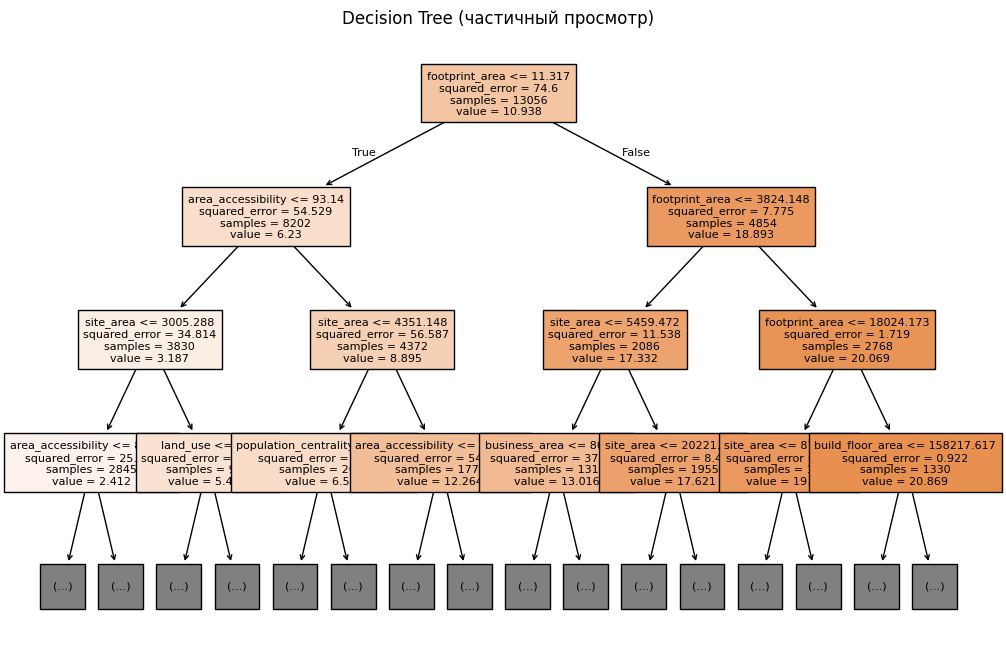

RF RMSE (log_price): 4.8487
RF RMSE (price_per_sqm): 513692717.16 RUB/m²
RF R² (price_per_sqm): 0.632


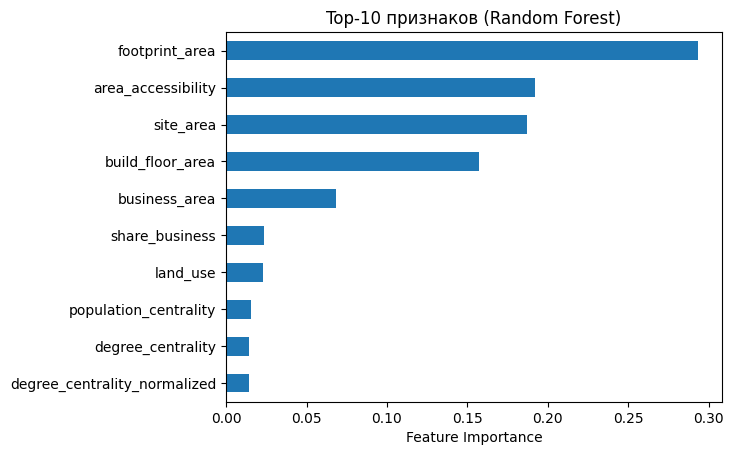

In [69]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1) Фильтрация только положительных цен


# 2) Признаки и таргет
feature_cols = [
    'land_use', 'is_living',
    'build_floor_area','living_demand','living_area','share_living',
    'business_area','share_business','site_area','population',
    'footprint_area','fsi','gsi','l','osr','mxi',
    'area_accessibility','degree_centrality',
    'population_normalized','degree_centrality_normalized',
    'population_centrality'
]
X = blocks[feature_cols].copy()
y = blocks['log_total_price']  # логарифм цены за м²

# 3) Кодируем категориальные признаки
for col in ['land_use','is_living']:
    X[col] = X[col].fillna('missing').astype(str).astype('category').cat.codes

# 4) Train-validation split (масштабировать не нужно!)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Вариант 1: простое дерево решений + GridSearch по глубине ===

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeRegressor(random_state=42)
grid_dt = GridSearchCV(
    dt, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("Лучшие параметры DecisionTree:", grid_dt.best_params_)

# Предсказание
y_pred_log_dt = best_dt.predict(X_val)
y_val_log = y_val.values  # уже в логах

# Метрики (лог-цена)
rmse_log_dt = np.sqrt(mean_squared_error(y_val_log, y_pred_log_dt))
print(f"DT RMSE (log_price): {rmse_log_dt:.4f}")

# Обратное преобразование в рубли
y_pred_price_dt = np.expm1(y_pred_log_dt)
y_val_price = np.expm1(y_val_log)
rmse_price_dt = np.sqrt(mean_squared_error(y_val_price, y_pred_price_dt))
r2_dt = r2_score(y_val_price, y_pred_price_dt)

print(f"DT RMSE (price_per_sqm): {rmse_price_dt:.2f} RUB/m²")
print(f"DT R² (price_per_sqm): {r2_dt:.3f}")

# (Опционально) визуализация небольшого дерева
plt.figure(figsize=(12,8))
plot_tree(best_dt,
          feature_names=feature_cols,
          max_depth=3,  # для читаемости
          filled=True,
          fontsize=8)
plt.title("Decision Tree (частичный просмотр)")
plt.show()


# === Вариант 2: случайный лес ===

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_log_rf = rf.predict(X_val)

# Метрики
rmse_log_rf = np.sqrt(mean_squared_error(y_val_log, y_pred_log_rf))
y_pred_price_rf = np.expm1(y_pred_log_rf)
rmse_price_rf = np.sqrt(mean_squared_error(y_val_price, y_pred_price_rf))
r2_rf = r2_score(y_val_price, y_pred_price_rf)

print(f"RF RMSE (log_price): {rmse_log_rf:.4f}")
print(f"RF RMSE (price_per_sqm): {rmse_price_rf:.2f} RUB/m²")
print(f"RF R² (price_per_sqm): {r2_rf:.3f}")

# Важность признаков
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False).head(10).plot.barh()
plt.xlabel("Feature Importance")
plt.title("Top-10 признаков (Random Forest)")
plt.gca().invert_yaxis()
plt.show()
